In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torch import nn
from torch import optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import json

c:\Users\User\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: GeForce RTX 3050 Ti Laptop GPU


In [ ]:
# ПІДГОТОВКА ДАНИХ 
dataset_path = "../dataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")
classes = os.listdir(train_path)
print(f"Класи: {classes}")

Класи: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))}")

glioma: 1321
meningioma: 1333
notumor: 1422
pituitary: 1445


In [ ]:
# Запис метаданних зображень у таблицю
def create_metadata_csv(folder_path, output_csv):
    data = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            data.append({"path": img_path, "label": class_name})
    
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    return df

# ПОДІЛ НА НАВЧАЛЬНУ ТА ТЕСТУВАЛЬНУ ВИБІРКИ
train_df = create_metadata_csv(train_path, "train_metadata.csv")
test_df = create_metadata_csv(test_path, "test_metadata.csv")

In [ ]:
# ПОДІЛ НА НАВЧАЛЬНУ ТА ВАЛІДАЦІЙНУ ВИБІРКИ
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df["label"]
)

In [ ]:
# ЗАСТОСУВАННЯ АУГМЕНТАЦІЙ ДО ЗОБРАЖЕНЬ
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(224, 224),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std),
    A.GaussNoise(mean=0, std=10, p=0.3),
    A.Rotate(limit=30, p=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

C:\Users\User\AppData\Local\Temp\ipykernel_20544\1022054748.py:8: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=10, p=0.3),


In [8]:
sample_path = train_df.iloc[10]["path"]
sample_label = train_df.iloc[10]["label"]
original_image = Image.open(sample_path).convert("RGB")

In [9]:
image_np = np.array(original_image)

augmented = train_transform(image=image_np)
augmented_image = augmented["image"]  # Тензор [C, H, W]


def denormalize(tensor):
    tensor = tensor.permute(1, 2, 0).numpy()  # [H, W, C]
    tensor = tensor * std + mean  # Зворотня нормалізація
    tensor = np.clip(tensor, 0, 1)  # Обрізка значень до [0, 1]
    return tensor

augmented_image_vis = denormalize(augmented_image)

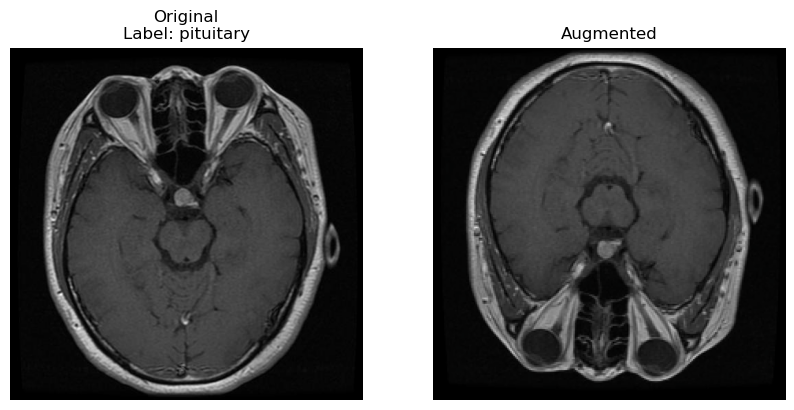

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title(f"Original\nLabel: {sample_label}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_vis)
plt.title("Augmented")
plt.axis("off")

plt.show()

In [11]:

print(f"Оригінальний розмір: {original_image.size}")  # (512, 512)
print(f"Після аугментації: {augmented_image.shape}")  # [3, 224, 224]

assert augmented_image_vis.min() >= 0 and augmented_image_vis.max() <= 1, "Нормалізація некоректна"

Оригінальний розмір: (512, 512)
Після аугментації: torch.Size([3, 224, 224])


In [ ]:
# Dataset для завантаження МРТ-знімків пухлин головного мозку та відповідних міток класів для задачі класифікації
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_idx = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["path"]
        label = self.dataframe.iloc[idx]["label"]
        
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        
        label_idx = self.label_to_idx[label]
        return image, label_idx

In [13]:
batch_size = 32

train_dataset = BrainTumorDataset(train_df, transform=train_transform)
val_dataset = BrainTumorDataset(val_df, transform=val_transform)
test_dataset = BrainTumorDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

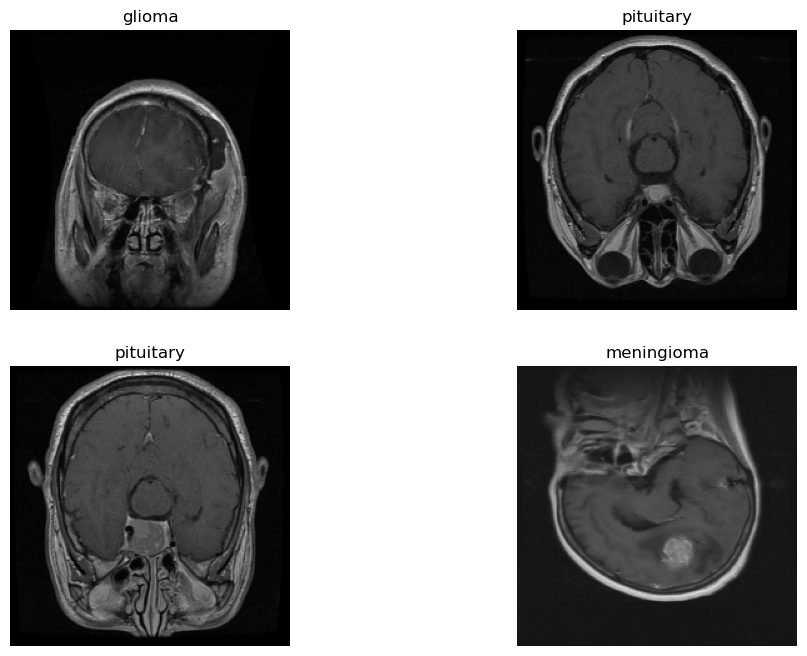

In [ ]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Денормалізація
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# Отримуємо 1 батч
images, labels = next(iter(train_loader))
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    imshow(images[i], class_names[labels[i]])
plt.show()

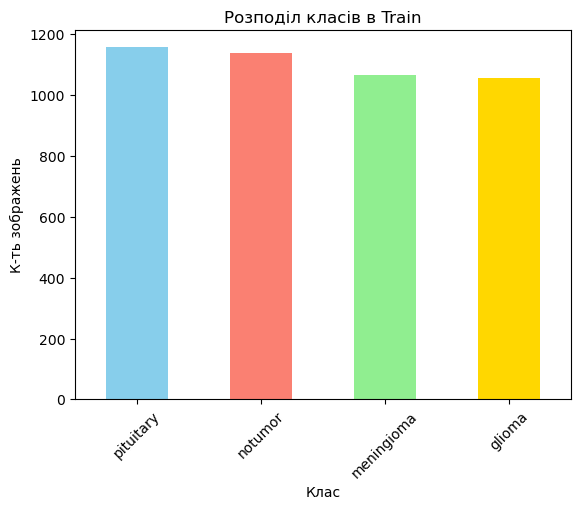

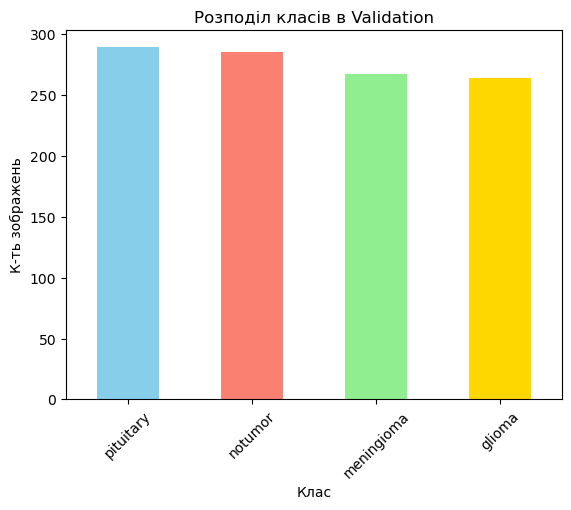

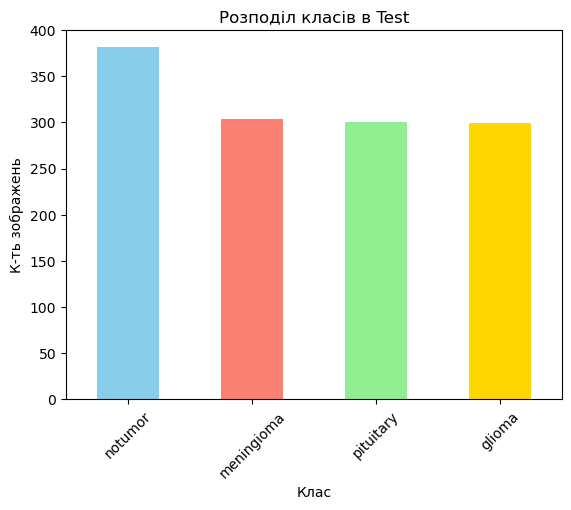

In [15]:
def plot_class_distribution(df, title):
    df["label"].value_counts().plot(kind="bar", color=["skyblue", "salmon", "lightgreen", "gold"])
    plt.title(title)
    plt.xlabel("Клас")
    plt.ylabel("К-ть зображень")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_df, "Розподіл класів в Train")
plot_class_distribution(val_df, "Розподіл класів в Validation")
plot_class_distribution(test_df, "Розподіл класів в Test")

In [ ]:
# Завантаження моделі
model = models.resnet50(pretrained=True).to(device)  # Завантаження моделі

# "Заморожування" всіх шарів, крім останнього блоку
for param in model.parameters():
    param.requires_grad = False  # Відключаємо градієнти для всіх шарів

c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_classes = 4  # glioma, meningioma, pituitary, notumor

# Замінюємо останній повнозв'язковий шар
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # Повнозв'язковий шар із 512 нейронами
    nn.ReLU(),
    nn.Dropout(0.5),  # Регуляризація для уникнення перенавчання
    nn.Linear(512, num_classes)  # Вихідний шар
).to(device)

In [18]:
# Розраховуємо ваги класів
class_counts = train_df["label"].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Зважена функція втрат

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # L2-регуляризація

# Планувальник learning rate (Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [ ]:
# РЕАЛІЗАЦІЯ РАННЬОЇ ЗУПИНКИ
class EarlyStopping:
    def __init__(self, patience=8, delta=0):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

early_stopper = EarlyStopping(patience=15, delta=0.001)

In [ ]:
# Функції одного циклу навчання та валідації моделі класифікації з використанням PyTorch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [22]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = correct / total
    return val_loss, val_acc

In [23]:
model = model.to(device)

best_val_acc = 0.0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

save_dir = "saved_models_ResNet"
os.makedirs(save_dir, exist_ok=True)

In [24]:

for epoch in range(1, 120):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step()

    # Зберігаємо історію
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Збереження найкращої моделі (за валідаційною точністю)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
        }, f"{save_dir}/best_resnet50_model.pth")

    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
        }, f"{save_dir}/model_epoch_{epoch}.pth")

    # Перевірка early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch {epoch}: "
      f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
      f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
      
with open(f"{save_dir}/training_history.json", "w") as f:
    json.dump(history, f)

Validation: 100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Epoch 1: Train Loss=1.0248, Train Acc=0.5897, Val Loss=0.5802, Val Acc=0.8326


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Epoch 2: Train Loss=0.7569, Train Acc=0.7142, Val Loss=0.4700, Val Acc=0.8471


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


Epoch 3: Train Loss=0.6878, Train Acc=0.7312, Val Loss=0.4190, Val Acc=0.8643


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.13it/s]


Epoch 4: Train Loss=0.6381, Train Acc=0.7570, Val Loss=0.3989, Val Acc=0.8715


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Epoch 5: Train Loss=0.6056, Train Acc=0.7699, Val Loss=0.3938, Val Acc=0.8724


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Epoch 6: Train Loss=0.5953, Train Acc=0.7645, Val Loss=0.3955, Val Acc=0.8570


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.19it/s]


Epoch 7: Train Loss=0.5891, Train Acc=0.7751, Val Loss=0.3732, Val Acc=0.8697


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Epoch 8: Train Loss=0.5734, Train Acc=0.7797, Val Loss=0.3722, Val Acc=0.8706


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.10it/s]


Epoch 9: Train Loss=0.5704, Train Acc=0.7790, Val Loss=0.3636, Val Acc=0.8760


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 10: Train Loss=0.5544, Train Acc=0.7926, Val Loss=0.3675, Val Acc=0.8697


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]


Epoch 11: Train Loss=0.5657, Train Acc=0.7806, Val Loss=0.3635, Val Acc=0.8715


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.25it/s]


Epoch 12: Train Loss=0.5561, Train Acc=0.7910, Val Loss=0.3617, Val Acc=0.8733


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.15it/s]


Epoch 13: Train Loss=0.5654, Train Acc=0.7831, Val Loss=0.3620, Val Acc=0.8697


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]


Epoch 14: Train Loss=0.5473, Train Acc=0.7919, Val Loss=0.3643, Val Acc=0.8715


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.36it/s]


Epoch 15: Train Loss=0.5632, Train Acc=0.7853, Val Loss=0.3727, Val Acc=0.8697


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Epoch 16: Train Loss=0.5652, Train Acc=0.7860, Val Loss=0.3775, Val Acc=0.8561


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]


Epoch 17: Train Loss=0.5591, Train Acc=0.7876, Val Loss=0.3564, Val Acc=0.8778


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 18: Train Loss=0.5768, Train Acc=0.7726, Val Loss=0.3645, Val Acc=0.8633


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.14it/s]


Epoch 19: Train Loss=0.5722, Train Acc=0.7736, Val Loss=0.3557, Val Acc=0.8697


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Epoch 20: Train Loss=0.5396, Train Acc=0.7930, Val Loss=0.3382, Val Acc=0.8805


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]


Epoch 21: Train Loss=0.5326, Train Acc=0.7960, Val Loss=0.3361, Val Acc=0.8751


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 22: Train Loss=0.5542, Train Acc=0.7788, Val Loss=0.3275, Val Acc=0.8833


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.27it/s]


Epoch 23: Train Loss=0.5231, Train Acc=0.7957, Val Loss=0.3419, Val Acc=0.8796


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Epoch 24: Train Loss=0.5285, Train Acc=0.7885, Val Loss=0.3491, Val Acc=0.8724


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.42it/s]


Epoch 25: Train Loss=0.4951, Train Acc=0.8111, Val Loss=0.3209, Val Acc=0.8851


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.35it/s]


Epoch 26: Train Loss=0.5069, Train Acc=0.8084, Val Loss=0.3370, Val Acc=0.8860


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]


Epoch 27: Train Loss=0.4980, Train Acc=0.8037, Val Loss=0.3147, Val Acc=0.8860


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.31it/s]


Epoch 28: Train Loss=0.4945, Train Acc=0.8084, Val Loss=0.3168, Val Acc=0.8851


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.32it/s]


Epoch 29: Train Loss=0.4899, Train Acc=0.8141, Val Loss=0.3153, Val Acc=0.8878


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.42it/s]


Epoch 30: Train Loss=0.5130, Train Acc=0.8007, Val Loss=0.3084, Val Acc=0.8869


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.40it/s]


Epoch 31: Train Loss=0.5064, Train Acc=0.7969, Val Loss=0.3119, Val Acc=0.8887


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.09it/s]


Epoch 32: Train Loss=0.4888, Train Acc=0.8105, Val Loss=0.3171, Val Acc=0.8878


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.38it/s]


Epoch 33: Train Loss=0.4918, Train Acc=0.8043, Val Loss=0.3145, Val Acc=0.8887


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.37it/s]


Epoch 34: Train Loss=0.4833, Train Acc=0.8195, Val Loss=0.3076, Val Acc=0.8923


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 35: Train Loss=0.4983, Train Acc=0.8077, Val Loss=0.3122, Val Acc=0.8905


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 36: Train Loss=0.5132, Train Acc=0.7955, Val Loss=0.3067, Val Acc=0.8950


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.26it/s]


Epoch 37: Train Loss=0.5022, Train Acc=0.8062, Val Loss=0.3067, Val Acc=0.8869


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.35it/s]


Epoch 38: Train Loss=0.4948, Train Acc=0.8028, Val Loss=0.3100, Val Acc=0.8914


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.36it/s]


Epoch 39: Train Loss=0.5252, Train Acc=0.7955, Val Loss=0.3509, Val Acc=0.8652


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.38it/s]


Epoch 40: Train Loss=0.5036, Train Acc=0.8025, Val Loss=0.3356, Val Acc=0.8824


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.03it/s]


Epoch 41: Train Loss=0.5105, Train Acc=0.7991, Val Loss=0.3174, Val Acc=0.8787


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.18it/s]


Epoch 42: Train Loss=0.4899, Train Acc=0.8114, Val Loss=0.3098, Val Acc=0.8887


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.30it/s]


Epoch 43: Train Loss=0.4970, Train Acc=0.8123, Val Loss=0.2978, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.37it/s]


Epoch 44: Train Loss=0.4820, Train Acc=0.8053, Val Loss=0.3314, Val Acc=0.8878


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 45: Train Loss=0.4824, Train Acc=0.8170, Val Loss=0.3191, Val Acc=0.8824


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.31it/s]


Epoch 46: Train Loss=0.4851, Train Acc=0.8145, Val Loss=0.2942, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Epoch 47: Train Loss=0.4631, Train Acc=0.8188, Val Loss=0.2954, Val Acc=0.8959


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.34it/s]


Epoch 48: Train Loss=0.4702, Train Acc=0.8204, Val Loss=0.2901, Val Acc=0.8923


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.37it/s]


Epoch 49: Train Loss=0.4686, Train Acc=0.8175, Val Loss=0.2838, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.42it/s]


Epoch 50: Train Loss=0.4590, Train Acc=0.8240, Val Loss=0.2866, Val Acc=0.8959


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.15it/s]


Epoch 51: Train Loss=0.4549, Train Acc=0.8225, Val Loss=0.2917, Val Acc=0.8923


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.26it/s]


Epoch 52: Train Loss=0.4621, Train Acc=0.8265, Val Loss=0.2827, Val Acc=0.8995


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.25it/s]


Epoch 53: Train Loss=0.4457, Train Acc=0.8261, Val Loss=0.2859, Val Acc=0.8968


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Epoch 54: Train Loss=0.4535, Train Acc=0.8286, Val Loss=0.2910, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.24it/s]


Epoch 55: Train Loss=0.4550, Train Acc=0.8263, Val Loss=0.2839, Val Acc=0.8932


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Epoch 56: Train Loss=0.4544, Train Acc=0.8211, Val Loss=0.2894, Val Acc=0.8941


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.30it/s]


Epoch 57: Train Loss=0.4670, Train Acc=0.8197, Val Loss=0.2944, Val Acc=0.8986


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.15it/s]


Epoch 58: Train Loss=0.4637, Train Acc=0.8213, Val Loss=0.2973, Val Acc=0.8959


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Epoch 59: Train Loss=0.4700, Train Acc=0.8175, Val Loss=0.2892, Val Acc=0.8878


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Epoch 60: Train Loss=0.4729, Train Acc=0.8093, Val Loss=0.2958, Val Acc=0.8923


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.20it/s]


Epoch 61: Train Loss=0.4594, Train Acc=0.8243, Val Loss=0.2893, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Epoch 62: Train Loss=0.4462, Train Acc=0.8247, Val Loss=0.2751, Val Acc=0.8959


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


Epoch 63: Train Loss=0.4678, Train Acc=0.8177, Val Loss=0.2727, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.24it/s]


Epoch 64: Train Loss=0.4598, Train Acc=0.8173, Val Loss=0.2687, Val Acc=0.9014


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.30it/s]


Epoch 65: Train Loss=0.4484, Train Acc=0.8250, Val Loss=0.2709, Val Acc=0.9050


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.08it/s]


Epoch 66: Train Loss=0.4470, Train Acc=0.8254, Val Loss=0.2679, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.26it/s]


Epoch 67: Train Loss=0.4326, Train Acc=0.8313, Val Loss=0.2660, Val Acc=0.9014


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.12it/s]


Epoch 68: Train Loss=0.4419, Train Acc=0.8306, Val Loss=0.2654, Val Acc=0.9014


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.24it/s]


Epoch 69: Train Loss=0.4356, Train Acc=0.8327, Val Loss=0.2692, Val Acc=0.9050


Validation: 100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Epoch 70: Train Loss=0.4400, Train Acc=0.8261, Val Loss=0.2665, Val Acc=0.9032


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.08it/s]


Epoch 71: Train Loss=0.4235, Train Acc=0.8401, Val Loss=0.2637, Val Acc=0.9050


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.11it/s]


Epoch 72: Train Loss=0.4296, Train Acc=0.8351, Val Loss=0.2603, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.05it/s]


Epoch 73: Train Loss=0.4307, Train Acc=0.8324, Val Loss=0.2646, Val Acc=0.8995


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Epoch 74: Train Loss=0.4273, Train Acc=0.8331, Val Loss=0.2652, Val Acc=0.9014


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Epoch 75: Train Loss=0.4275, Train Acc=0.8361, Val Loss=0.2675, Val Acc=0.9023


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 76: Train Loss=0.4350, Train Acc=0.8311, Val Loss=0.2758, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.51it/s]


Epoch 77: Train Loss=0.4490, Train Acc=0.8207, Val Loss=0.2881, Val Acc=0.8914


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Epoch 78: Train Loss=0.4383, Train Acc=0.8240, Val Loss=0.2686, Val Acc=0.8968


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.57it/s]


Epoch 79: Train Loss=0.4452, Train Acc=0.8204, Val Loss=0.2639, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.52it/s]


Epoch 80: Train Loss=0.4702, Train Acc=0.8143, Val Loss=0.2685, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Epoch 81: Train Loss=0.4350, Train Acc=0.8331, Val Loss=0.2876, Val Acc=0.8950


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.57it/s]


Epoch 82: Train Loss=0.4367, Train Acc=0.8342, Val Loss=0.2527, Val Acc=0.9077


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 83: Train Loss=0.4370, Train Acc=0.8313, Val Loss=0.2654, Val Acc=0.9041


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.44it/s]


Epoch 84: Train Loss=0.4240, Train Acc=0.8324, Val Loss=0.2620, Val Acc=0.8995


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Epoch 85: Train Loss=0.4213, Train Acc=0.8333, Val Loss=0.2520, Val Acc=0.9041


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.45it/s]


Epoch 86: Train Loss=0.4141, Train Acc=0.8354, Val Loss=0.2499, Val Acc=0.9068


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.54it/s]


Epoch 87: Train Loss=0.4231, Train Acc=0.8404, Val Loss=0.2528, Val Acc=0.8977


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Epoch 88: Train Loss=0.4082, Train Acc=0.8347, Val Loss=0.2478, Val Acc=0.9041


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.53it/s]


Epoch 89: Train Loss=0.4062, Train Acc=0.8444, Val Loss=0.2436, Val Acc=0.9113


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.52it/s]


Epoch 90: Train Loss=0.3935, Train Acc=0.8453, Val Loss=0.2495, Val Acc=0.9032


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.54it/s]


Epoch 91: Train Loss=0.3939, Train Acc=0.8469, Val Loss=0.2416, Val Acc=0.9059


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]


Epoch 92: Train Loss=0.3895, Train Acc=0.8487, Val Loss=0.2439, Val Acc=0.9041


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.52it/s]


Epoch 93: Train Loss=0.4049, Train Acc=0.8483, Val Loss=0.2487, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.53it/s]


Epoch 94: Train Loss=0.3988, Train Acc=0.8433, Val Loss=0.2430, Val Acc=0.9113


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]


Epoch 95: Train Loss=0.4203, Train Acc=0.8397, Val Loss=0.2405, Val Acc=0.9095


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Epoch 96: Train Loss=0.4120, Train Acc=0.8401, Val Loss=0.2457, Val Acc=0.9023


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Epoch 97: Train Loss=0.4109, Train Acc=0.8394, Val Loss=0.2564, Val Acc=0.8995


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.38it/s]


Epoch 98: Train Loss=0.4265, Train Acc=0.8342, Val Loss=0.2532, Val Acc=0.9032


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.46it/s]


Epoch 99: Train Loss=0.4247, Train Acc=0.8367, Val Loss=0.2530, Val Acc=0.9032


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.54it/s]


Epoch 100: Train Loss=0.4308, Train Acc=0.8327, Val Loss=0.2425, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Epoch 101: Train Loss=0.4160, Train Acc=0.8327, Val Loss=0.2378, Val Acc=0.9104


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.48it/s]


Epoch 102: Train Loss=0.4270, Train Acc=0.8284, Val Loss=0.2392, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.14it/s]


Epoch 103: Train Loss=0.4178, Train Acc=0.8347, Val Loss=0.2391, Val Acc=0.9095


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.45it/s]


Epoch 104: Train Loss=0.4106, Train Acc=0.8413, Val Loss=0.2384, Val Acc=0.9113


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.45it/s]


Epoch 105: Train Loss=0.4089, Train Acc=0.8397, Val Loss=0.2276, Val Acc=0.9176


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Epoch 106: Train Loss=0.4083, Train Acc=0.8428, Val Loss=0.2324, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.50it/s]


Epoch 107: Train Loss=0.3807, Train Acc=0.8558, Val Loss=0.2275, Val Acc=0.9149


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 108: Train Loss=0.3980, Train Acc=0.8519, Val Loss=0.2286, Val Acc=0.9113


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.48it/s]


Epoch 109: Train Loss=0.3833, Train Acc=0.8512, Val Loss=0.2259, Val Acc=0.9140


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.51it/s]


Epoch 110: Train Loss=0.3805, Train Acc=0.8537, Val Loss=0.2310, Val Acc=0.9077


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 111: Train Loss=0.3768, Train Acc=0.8519, Val Loss=0.2236, Val Acc=0.9131


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.52it/s]


Epoch 112: Train Loss=0.3818, Train Acc=0.8567, Val Loss=0.2250, Val Acc=0.9086


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.53it/s]


Epoch 113: Train Loss=0.3864, Train Acc=0.8476, Val Loss=0.2206, Val Acc=0.9186


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.54it/s]


Epoch 114: Train Loss=0.3973, Train Acc=0.8510, Val Loss=0.2286, Val Acc=0.9059


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.47it/s]


Epoch 115: Train Loss=0.3938, Train Acc=0.8449, Val Loss=0.2254, Val Acc=0.9050


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.38it/s]


Epoch 116: Train Loss=0.3852, Train Acc=0.8447, Val Loss=0.2271, Val Acc=0.9176


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Epoch 117: Train Loss=0.4072, Train Acc=0.8426, Val Loss=0.2468, Val Acc=0.9005


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.55it/s]


Epoch 118: Train Loss=0.4080, Train Acc=0.8356, Val Loss=0.2283, Val Acc=0.9113


Validation: 100%|██████████| 35/35 [00:06<00:00,  5.41it/s]

Epoch 119: Train Loss=0.4049, Train Acc=0.8406, Val Loss=0.2258, Val Acc=0.9167


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

      glioma       0.96      0.81      0.88       299
  meningioma       0.79      0.81      0.80       304
     notumor       0.92      0.98      0.95       381
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284



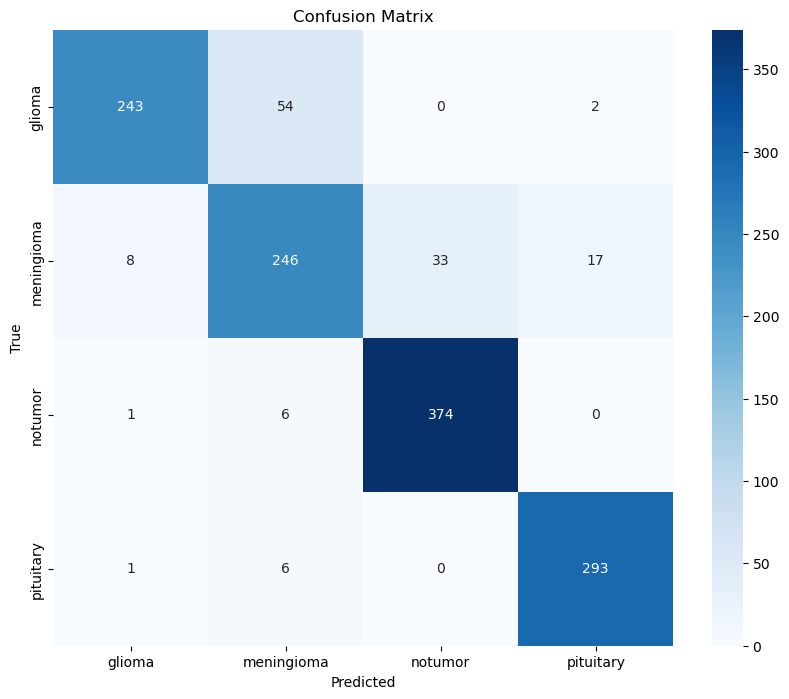

In [ ]:

num_classes = 4
model = models.resnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)
checkpoint = torch.load("saved_models_ResNet/best_resnet50_model.pth")

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

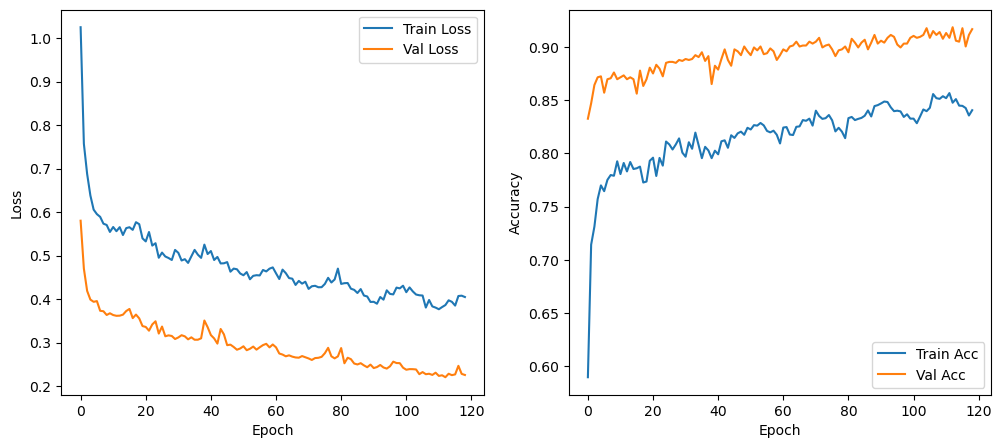

In [26]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{save_dir}/training_plot.png")
plt.show()

              precision    recall  f1-score   support

      glioma       0.96      0.81      0.88       299
  meningioma       0.79      0.81      0.80       304
     notumor       0.92      0.98      0.95       381
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284



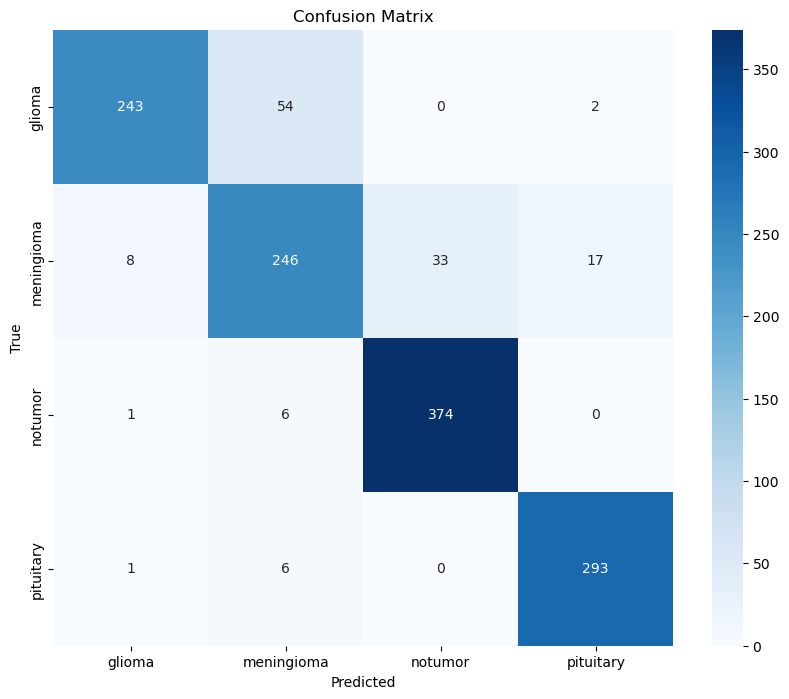


Class: glioma
Sensitivity (Recall): 0.8127
Specificity: 0.9898

Class: meningioma
Sensitivity (Recall): 0.8092
Specificity: 0.9327

Class: notumor
Sensitivity (Recall): 0.9816
Specificity: 0.9635

Class: pituitary
Sensitivity (Recall): 0.9767
Specificity: 0.9807
AUC-ROC for class glioma: 0.9906
AUC-ROC for class meningioma: 0.9603
AUC-ROC for class notumor: 0.9979
AUC-ROC for class pituitary: 0.9965

Macro-average AUC-ROC: 0.9863


In [ ]:


all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{save_dir}/confusion_matrix.png")
plt.show()

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Sensitivity (Recall): {sensitivity[i]:.4f}")
    print(f"Specificity: {specificity[i]:.4f}")


y_true_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # [glioma, meningioma, notumor, pituitary]
y_score = np.array(all_probs)

auc_scores = roc_auc_score(y_true_bin, y_score, average=None)

for i, class_name in enumerate(class_names):
    print(f"AUC-ROC for class {class_name}: {auc_scores[i]:.4f}")

macro_auc = roc_auc_score(y_true_bin, y_score, average="macro")
print(f"\nMacro-average AUC-ROC: {macro_auc:.4f}")

In [28]:
def add_gaussian_noise(image, mean=0, std=10):
    """Додає гаусівський шум до зображення (uint8)."""
    noisy = image + np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

=== Classification report (з шумом) ===
              precision    recall  f1-score   support

      glioma       0.96      0.69      0.80       299
  meningioma       0.71      0.80      0.76       304
     notumor       0.94      0.94      0.94       381
   pituitary       0.84      0.98      0.91       300

    accuracy                           0.86      1284
   macro avg       0.86      0.85      0.85      1284
weighted avg       0.87      0.86      0.85      1284



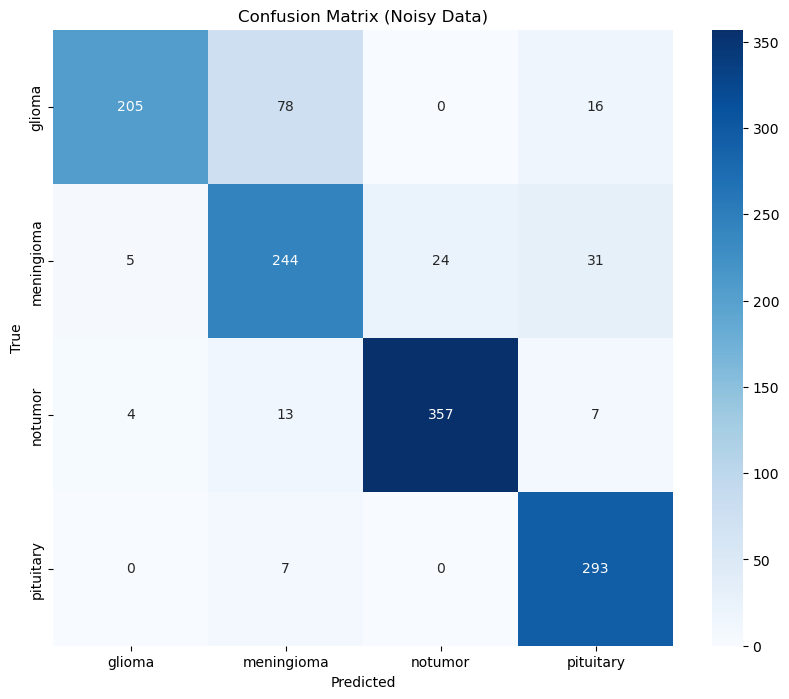

In [29]:
class NoisyBrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_idx = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["path"]
        label = self.dataframe.iloc[idx]["label"]

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        image = add_gaussian_noise(image)  # Додаємо шум

        if self.transform:
            image = self.transform(image=image)["image"]

        label_idx = self.label_to_idx[label]
        return image, label_idx

noisy_test_dataset = NoisyBrainTumorDataset(test_df, transform=val_transform)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)


noisy_preds = []
noisy_labels = []

model.eval()
with torch.no_grad():
    for images, labels in noisy_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        noisy_preds.extend(preds.cpu().numpy())
        noisy_labels.extend(labels.cpu().numpy())

print("=== Classification report (з шумом) ===")
print(classification_report(noisy_labels, noisy_preds, target_names=class_names))

# Матриця плутанини
cm = confusion_matrix(noisy_labels, noisy_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Noisy Data)")
plt.show()